<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part8/P8_CH01_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 손상된 의류 이미지 화질 복구하기
- AutoEncoder
- FashionMNIST

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

## 1. EDA

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


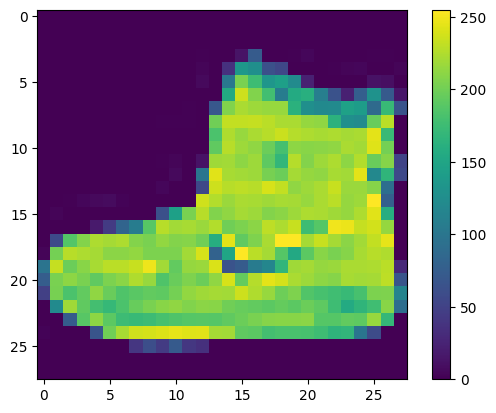

In [4]:
plt.imshow(train_images[0])
plt.colorbar()
plt.show()

In [5]:
list(filter(lambda x : x!=0, train_images[0].reshape(-1)))[:10]

[1, 13, 73, 1, 4, 1, 1, 3, 36, 136]

In [6]:
train_images.dtype

dtype('uint8')

## 2. 전처리

In [7]:
print(list(filter(lambda x : x!=0, train_images[0].reshape(-1)))[:10])
print(list(filter(lambda x : x!=0, test_images[0].reshape(-1)))[:10])

[1, 13, 73, 1, 4, 1, 1, 3, 36, 136]
[3, 1, 7, 37, 1, 2, 27, 84, 11, 119]


In [8]:
print(min(train_images[0].reshape(-1)), max(train_images[0].reshape(-1)))
print(min(test_images[0].reshape(-1)), max(test_images[0].reshape(-1)))

0 255
0 255


In [9]:
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

print(train_images.dtype, test_images.dtype)

float64 float64


In [10]:
### 0-1 normalize
train_images = train_images /255.0
test_images = test_images /255.0

In [11]:
print(min(train_images[0].reshape(-1)), max(train_images[0].reshape(-1)))
print(min(test_images[0].reshape(-1)), max(test_images[0].reshape(-1)))

0.0 1.0
0.0 1.0


In [12]:
from skimage import color
print(train_images.shape)
print(color.gray2rgb(train_images[0]).shape) ## 컬러 이미지 형식으로 변경 (채널 확장)

(60000, 28, 28)
(28, 28, 3)


In [13]:
train_images = np.array([color.gray2rgb(img) for img in train_images])
test_images = np.array([color.gray2rgb(img) for img in test_images])

print(train_images.shape, test_images.shape)

(60000, 28, 28, 3) (10000, 28, 28, 3)


## 3. Visualization

In [14]:
train_images[:5].shape

(5, 28, 28, 3)

In [15]:
train_images[:5].transpose(1,0,2,3).reshape(28, 5*28, -1).shape

(28, 140, 3)

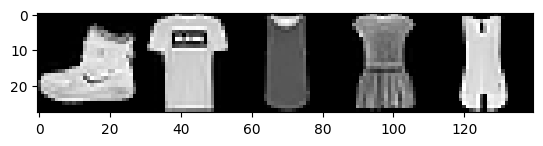

In [16]:
plt.imshow(train_images[:5].transpose(1,0,2,3).reshape(28, 5*28, -1))

## 4. Data augmentation - Noise 추가

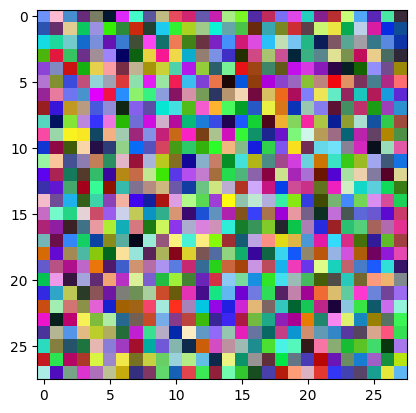

In [17]:
plt.imshow(np.random.random((28,28,3)))
plt.show()

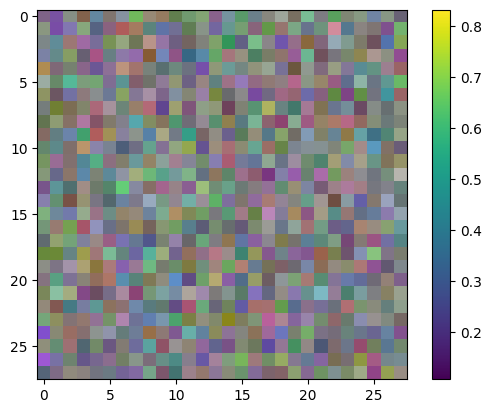

In [18]:
## 가우시안 noise
noisy = np.random.normal(0.5, 0.1, (28,28,3))
noisy[noisy > 1.0] = 1.0
plt.imshow(noisy)
plt.colorbar()
plt.show()

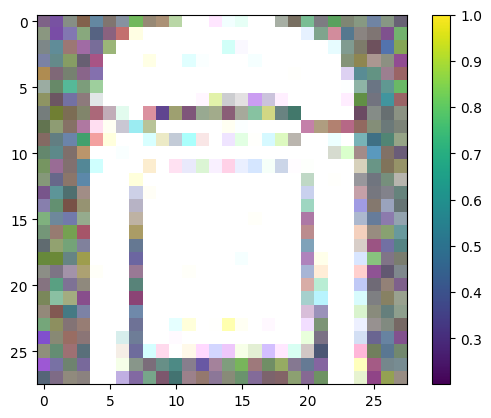

In [19]:
# 한 장의 이미지에 노이즈 추가
noisy_image = train_images[5] + noisy
noisy_image[noisy_image > 1.0] = 1.0

plt.imshow(noisy_image)
plt.colorbar()
plt.show()

In [20]:
train_noisy_images = train_images + np.random.normal(0.5, 0.05, train_images.shape)
train_noisy_images[train_noisy_images > 1.0] = 1.0

test_noisy_images = test_images + np.random.normal(0.5, 0.05, test_images.shape)
test_noisy_images[test_noisy_images > 1.0] = 1.0

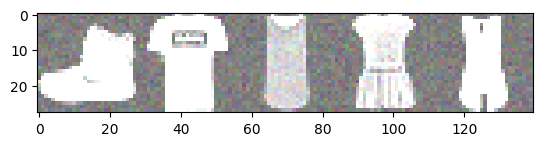

In [21]:
# 노이즈 이미지 5장 출력
plt.imshow(train_noisy_images[:5].transpose(1,0,2,3).reshape(28, 5*28, 3))
plt.show()

## 5. 모델링 - AutoEncoder

In [22]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model

In [23]:
inputs = Input(shape = (28,28,3))
x = Conv2D(32, 3, 2, activation='relu', padding = 'same')(inputs)
x = Conv2D(64, 3, 2, activation='relu', padding = 'same')(x)
x = Flatten()(x)
latent = Dense(10)(x) # latent vector

x = Dense(7*7*64)(latent)
x = Reshape((7,7,64))(x)
x = Conv2DTranspose(64, 3, 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(32, 3, 2, activation = 'relu', padding = 'same')(x)
x = Conv2DTranspose(3, 3, activation = 'sigmoid', padding = 'same')(x)

model = Model(inputs, x)


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 10)                31370     
                                                                 
 dense_1 (Dense)             (None, 3136)              34496     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0     

In [25]:
model.compile(loss = 'mse',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [26]:
hist = model.fit(train_noisy_images, train_images,
                 validation_data=(test_noisy_images, test_images),
                 epochs = 5,
                 verbose = 2)

Epoch 1/5
1875/1875 - 21s - loss: 0.0298 - accuracy: 0.3710 - val_loss: 0.0193 - val_accuracy: 0.3539 - 21s/epoch - 11ms/step
Epoch 2/5
1875/1875 - 9s - loss: 0.0185 - accuracy: 0.3615 - val_loss: 0.0176 - val_accuracy: 0.3947 - 9s/epoch - 5ms/step
Epoch 3/5
1875/1875 - 9s - loss: 0.0170 - accuracy: 0.3891 - val_loss: 0.0163 - val_accuracy: 0.4014 - 9s/epoch - 5ms/step
Epoch 4/5
1875/1875 - 12s - loss: 0.0162 - accuracy: 0.3753 - val_loss: 0.0159 - val_accuracy: 0.3536 - 12s/epoch - 7ms/step
Epoch 5/5
1875/1875 - 16s - loss: 0.0156 - accuracy: 0.3609 - val_loss: 0.0157 - val_accuracy: 0.3568 - 16s/epoch - 9ms/step


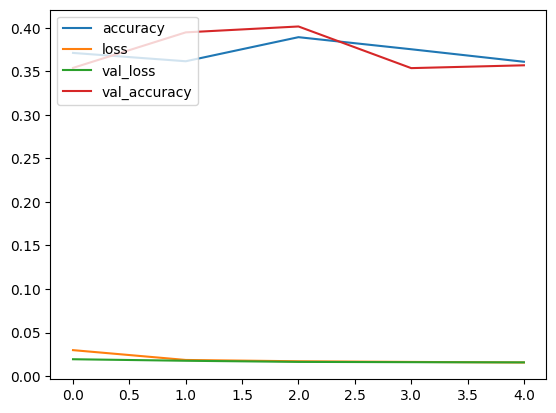

In [27]:
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')
plt.show()

## 6. 결과 확인

1/1 [==============================] - 0s 36ms/step


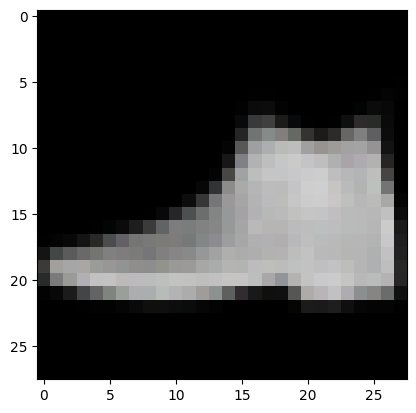

In [44]:
res = model.predict(test_noisy_images[0:1])
plt.imshow(res.reshape(28,28,3))

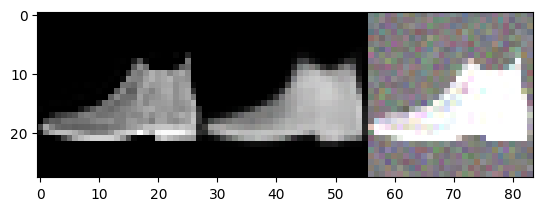

In [45]:
plt.imshow(np.concatenate([test_images[0],res[0],test_noisy_images[0]], axis = 1))
plt.show()

1/1 [==============================] - 0s 37ms/step


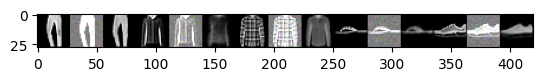

In [59]:
five_res = model.predict(test_noisy_images[5:10])

result = np.concatenate([test_images[5:10], test_noisy_images[5:10], five_res], axis=2).transpose(1, 0, 2, 3).reshape((28, -1, 3))
plt.imshow(result)